In [4]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile

from sklearn import model_selection

os.getcwd()

'C:\\Users\\SandersLi\\Camino'

In [6]:
SENTIMENT_LABELS = [
    "negative", "somewhat negative", "neutral", "somewhat positive", "positive"
]

# Add a column with readable values representing the sentiment.
def add_readable_labels_column(df, sentiment_value_column):
  df["SentimentLabel"] = df[sentiment_value_column].replace(
      range(5), SENTIMENT_LABELS)
    
# Download data from Kaggle and create a DataFrame.
def load_data_from_zip(path):
  with zipfile.ZipFile(path, "r") as zip_ref:
    name = zip_ref.namelist()[0]
    with zip_ref.open(name) as zf:
      return pd.read_csv(zf, sep="\t", index_col=0)


# The data does not come with a validation set so we'll create one from the
# training set.
def get_data(competition, train_file, test_file, validation_set_ratio=0.1):
  train_df = load_data_from_zip(train_file)
  test_df = load_data_from_zip(test_file)

  # Add a human readable label.
  add_readable_labels_column(train_df, "Sentiment")

  # We split by sentence ids, because we don't want to have phrases belonging
  # to the same sentence in both training and validation set.
  train_indices, validation_indices = model_selection.train_test_split(
      np.unique(train_df["SentenceId"]),
      test_size=validation_set_ratio,
      random_state=0)

  validation_df = train_df[train_df["SentenceId"].isin(validation_indices)]
  train_df = train_df[train_df["SentenceId"].isin(train_indices)]
  print("Split the training data into %d training and %d validation examples." %
        (len(train_df), len(validation_df)))

  return train_df, validation_df, test_df


train_df, validation_df, test_df = get_data(
    "sentiment-analysis-on-movie-reviews",
    "train.tsv.zip", "test.tsv.zip")

Split the training data into 140315 training and 15745 validation examples.


In [7]:
class MyModel(tf.keras.Model):
  def __init__(self, hub_url):
    super().__init__()
    self.hub_url = hub_url
    self.embed = hub.load(self.hub_url).signatures['default']
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.Dense(500),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Dense(5),
    ])

  def call(self, inputs):
    phrases = inputs['Phrase'][:,0]
    embedding = 5*self.embed(phrases)['default']
    return self.sequential(embedding)

  def get_config(self):
    return {"hub_url":self.hub_url}

In [8]:
model = MyModel("https://tfhub.dev/google/nnlm-en-dim128/1")
model.compile(
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.optimizers.Adam(), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [9]:
history = model.fit(x=dict(train_df), y=train_df['Sentiment'],
          validation_data=(dict(validation_df), validation_df['Sentiment']),
          epochs = 25)

Epoch 1/25
4385/4385 [==============================] - 16s 4ms/step - loss: 1.0235 - accuracy: 0.5862 - val_loss: 1.0020 - val_accuracy: 0.5912
Epoch 2/25
4385/4385 [==============================] - 15s 4ms/step - loss: 0.9997 - accuracy: 0.5944 - val_loss: 0.9926 - val_accuracy: 0.5923
Epoch 3/25
4385/4385 [==============================] - 16s 4ms/step - loss: 0.9955 - accuracy: 0.5965 - val_loss: 0.9946 - val_accuracy: 0.5915
Epoch 4/25
4385/4385 [==============================] - 16s 4ms/step - loss: 0.9930 - accuracy: 0.5972 - val_loss: 0.9830 - val_accuracy: 0.5916
Epoch 5/25
4385/4385 [==============================] - 15s 4ms/step - loss: 0.9919 - accuracy: 0.5982 - val_loss: 0.9824 - val_accuracy: 0.5989
Epoch 6/25
4385/4385 [==============================] - 17s 4ms/step - loss: 0.9908 - accuracy: 0.5985 - val_loss: 0.9883 - val_accuracy: 0.5906
Epoch 7/25
4385/4385 [==============================] - 21s 5ms/step - loss: 0.9899 - accuracy: 0.5991 - val_loss: 0.9815 - val_ac

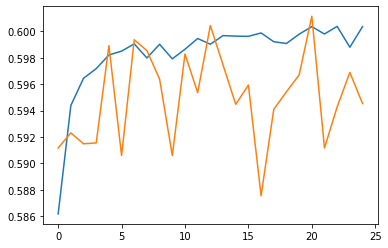

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [11]:
train_eval_result = model.evaluate(dict(train_df), train_df['Sentiment'])
validation_eval_result = model.evaluate(dict(validation_df), validation_df['Sentiment'])

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

493/493 [==============================] - 1s 2ms/step - loss: 0.9844 - accuracy: 0.5945
Training set accuracy: 0.5969995856285095
Validation set accuracy: 0.5945379734039307
